# Chapter 4 - The MA Model

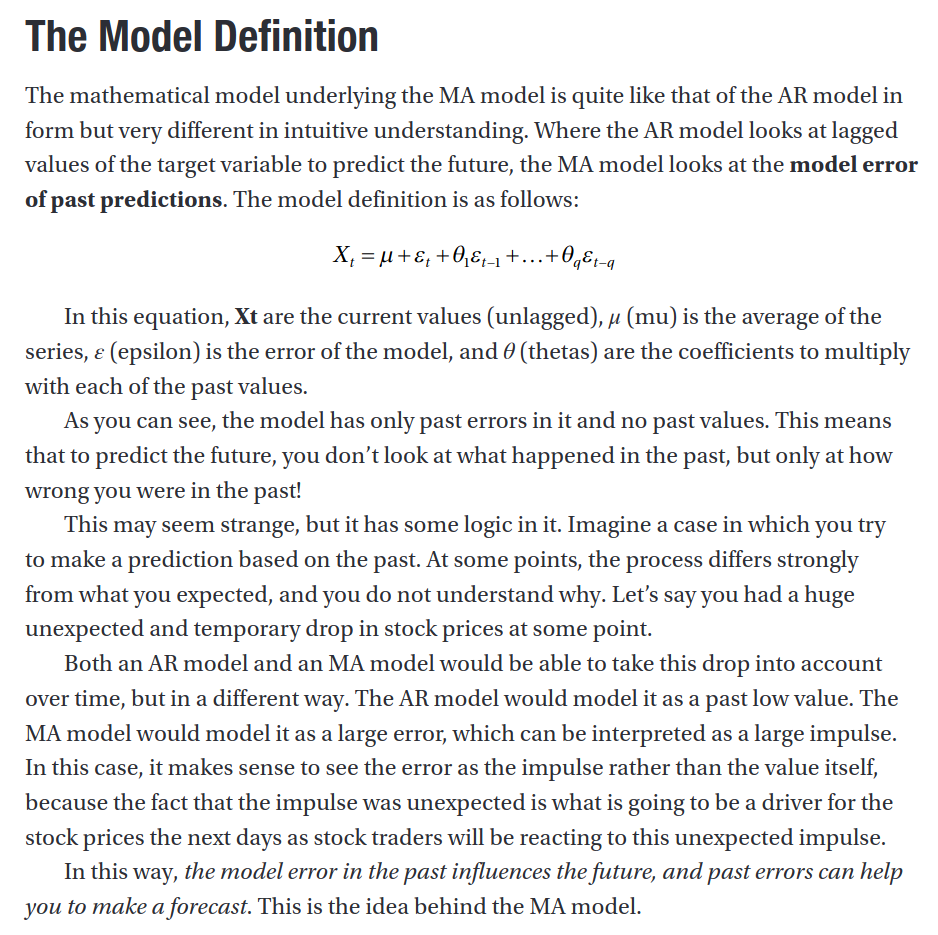

## Note
The term moving average is also used for taking the average of the most
recent values. In time series, this is often used for smoothing a time series. This has nothing to do with the MA model.

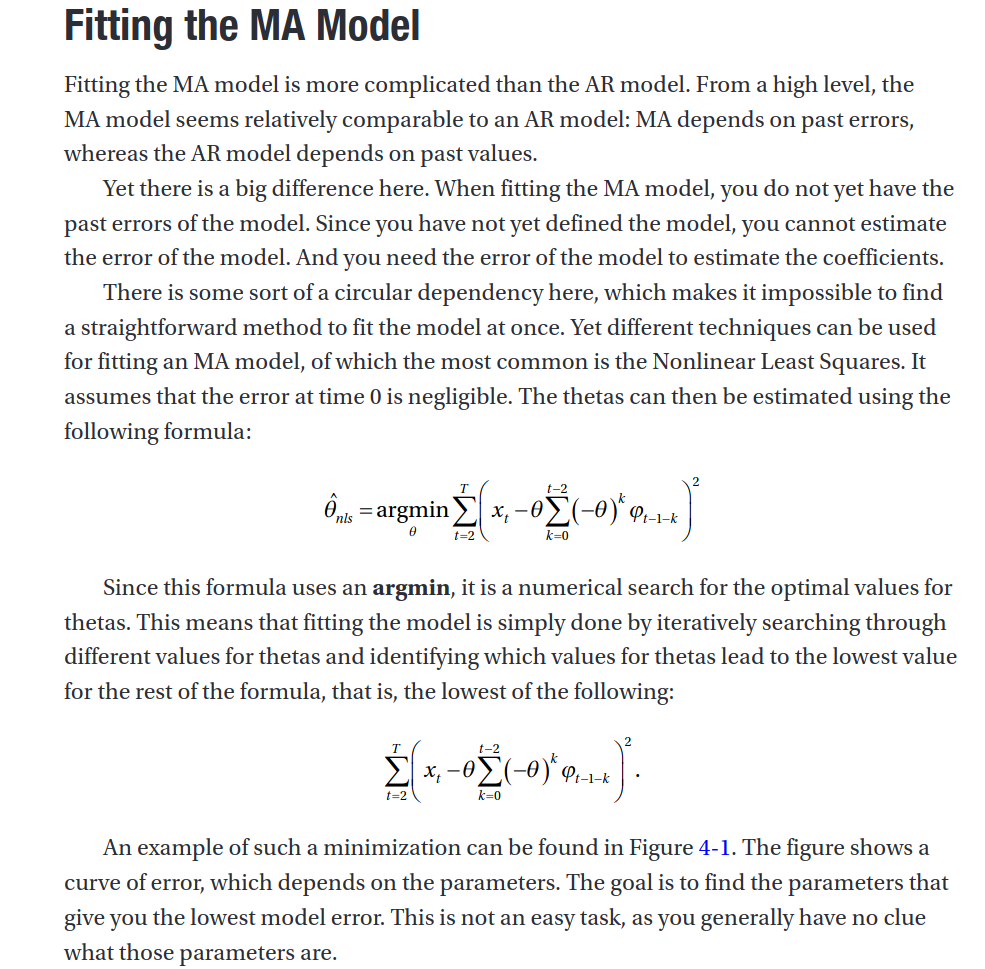

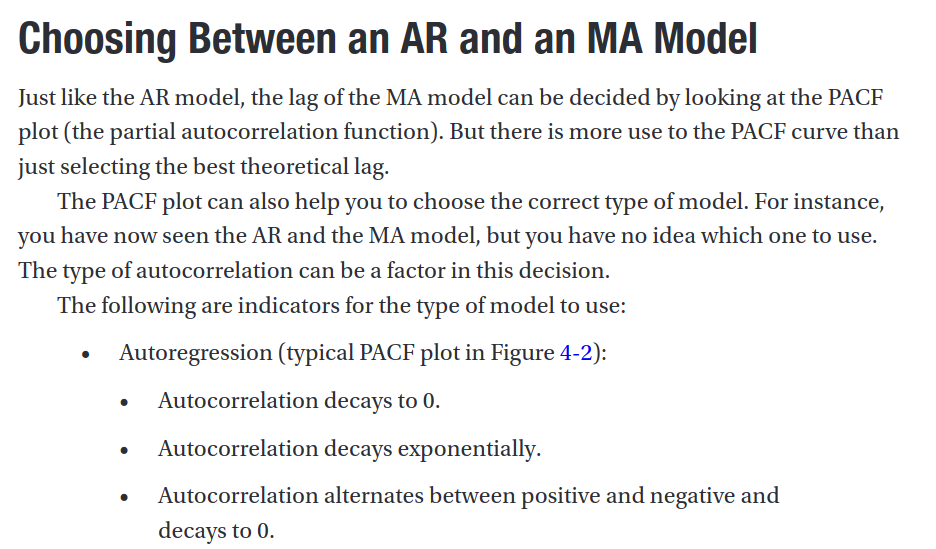

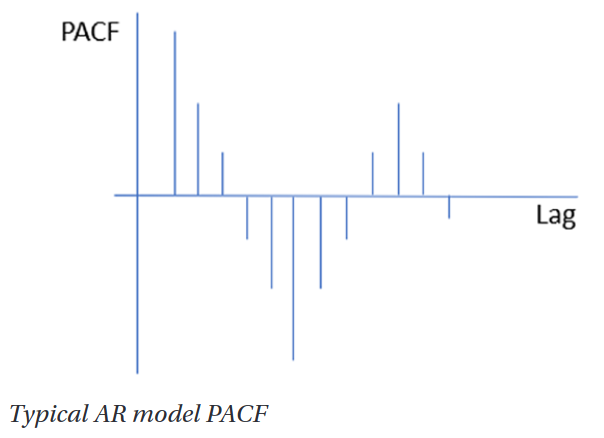

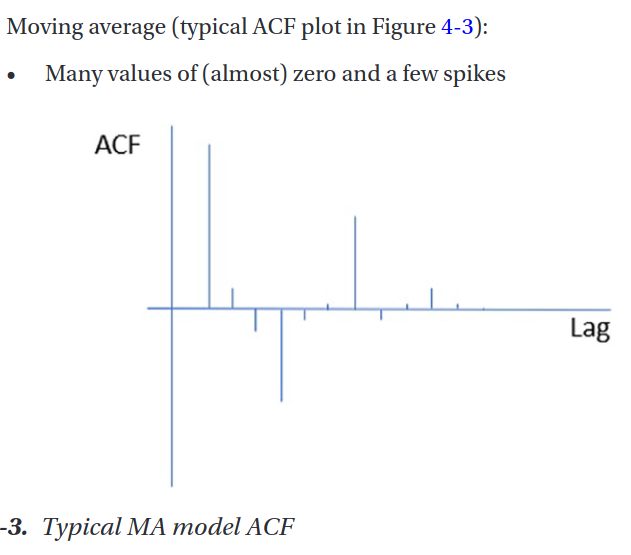

##Application of the MA Model

## Listing 4-1. Importing Stock Price data using Yahoo Finance package

In [ ]:
#!pip install yfinance

import yfinance as yf

data = yf.download('MSFT', start='2019-01-01', end='2021-07-31')

data = data['Close']


[*********************100%%**********************]  1 of 1 completed


## Listing 4-2. Plotting the Stock Price data

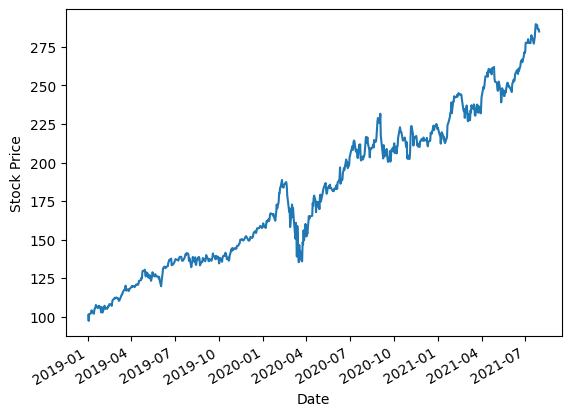

In [ ]:
import matplotlib.pyplot as plt
ax = data.plot()
ax.set_ylabel("Stock Price")
plt.show()


In this graph, you can clearly see an upward trend. It is not even necessary to apply an Augmented Dickey Fuller (ADF) test here to see that this data is not stationary.

Since the MA model cannot function without stationarity, let’s apply the go-to solution:

**Differencing**

## Listing 4-3. Computing the differenced data and plotting it

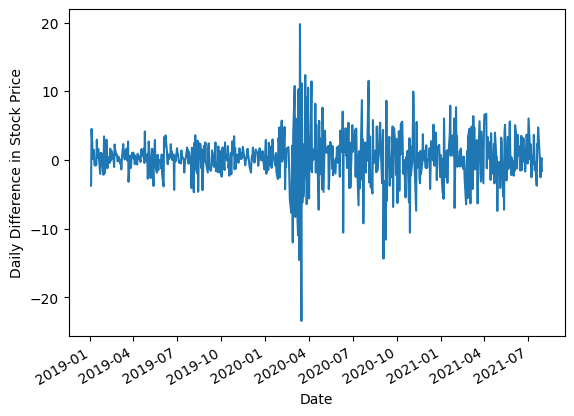

In [ ]:
# Need to difference
data = data.diff().dropna()
ax = data.plot()
ax.set_ylabel("Daily Difference in Stock Price")
plt.show()


This differenced data seems stationary. For consistency’s sake, Listing 4-4 shows how to use an Augmented Dickey Fuller test on these differences, although by visual inspection, there is really no doubt about it: the data is clearly varying around a fixed mean of 0.

## Listing 4-4. Applying an ADF test to the differenced data

In [ ]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(data)
pvalue = result[1]
if pvalue < 0.05:
    print('stationary')
else:
    print('not stationary')


stationary


This confirms stationarity of the differenced series. Let’s have a look at the
autocorrelation and partial autocorrelation functions to see whether there is an obvious choice for the lag using the ACF and the PACF

## Listing 4-5. Plotting the Autocorrelation Function and the Partial Autocorrelation Function

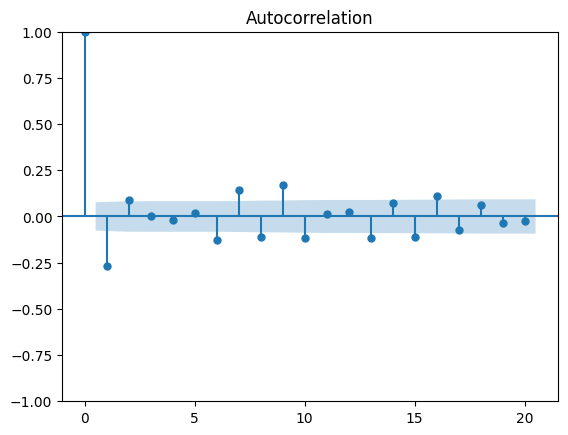

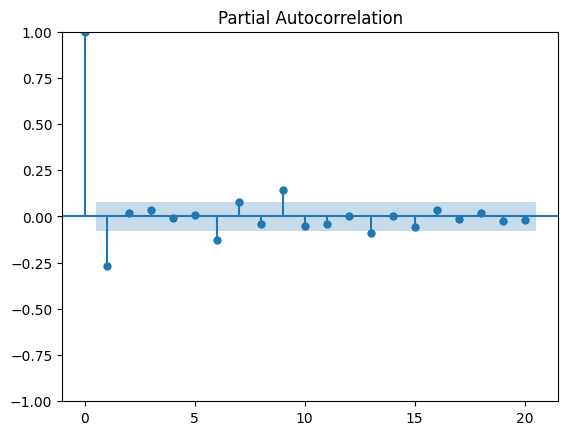

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data, lags=20)
plot_pacf(data, lags=20)
plt.show()


Unfortunately, there is not a very clear pattern in the autocorrelation nor partial autocorrelation that would confirm a choice for the order. You can observe some decay in the partial autocorrelation function, which is a positive sign for using a time series approach. But nothing too obvious on the choice of lag. Let’s fit the MA model with order 1 and see what it does.

To fit the MA model in Python, you need to use the ARIMA function from
statsmodels. ARIMA is a model that you will see in a next chapter. It is a model that contains multiple building blocks of univariate time series, including AR for the AR model and MA for the MA model. You can specify the order for each of the “smaller” models separately, so by setting everything except MA to 0, you obtain the MA model.

## Listing 4-6. Fitting the MA model and plotting the forecast

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


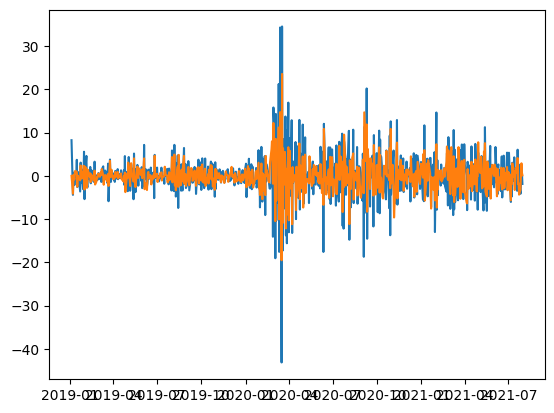

0.6030305996178613


In [ ]:
from sklearn.metrics import r2_score
from statsmodels.tsa.arima.model import ARIMA

# Forecast the first MA(1) model
mod = ARIMA(data.diff().dropna(), order=(0,0,1))
res = mod.fit()

orig_data = data.diff().dropna()
pred = res.predict()

plt.plot(orig_data)
plt.plot(pred)
plt.show()

print(r2_score(orig_data, pred))


This plot looks not too bad: the orange curve (predicted) follows the general trend in the blue curve (actual values). You can observe that the predicted curve is less extreme in its predictions (the highs are less high, and the lows are less low). The R2 score is 0.51.

As an interpretation, you could observe that there is an underfit in this model: it does capture the basics, but it does not capture enough of the trend to be a very good model. At this stage, you can already have a check of its out-of-sample performance by creating a train and a test set.

## Listing 4-7. Fitting the MA model on train data and evaluation the R2 score on train and test data

In [ ]:
train = data.diff().dropna()[0:240]
test = data.diff().dropna()[240:250]

# Forecast the first MA(1) model
mod = ARIMA(train, order=(0,0,1))
res = mod.fit()

orig_data = data.diff().dropna()
pred = res.predict()
fcst = res.forecast(steps = len(test))

print(r2_score(train, pred))
print(r2_score(test, fcst))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


0.5152180905737991
0.11727086877444359


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


## Listing 4-8. Plotting the out of sample forecast of the MA(1) model (MA with order 1)

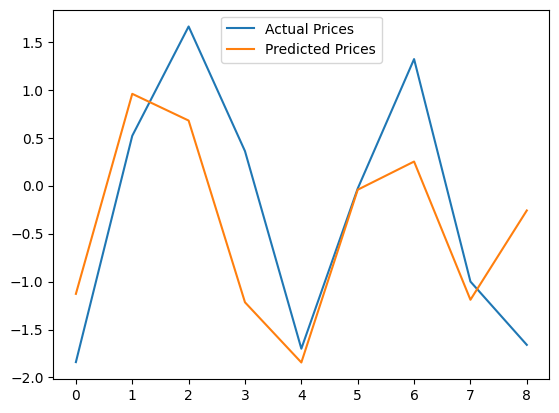

In [ ]:
plt.plot(list(test))
plt.plot(list(fcst))
plt.legend(['Actual Prices', 'Predicted Prices'])
plt.show()


But when looking at this visual, you can see that there is something weird going on with the forecast on the test set. The MA(1) forecast has forecasted the average for every value except for the first step into the future.
And there is a mathematical reason for this: the MA(q) model uses the model error of the past q steps to predict the future. When predicting one step into the future, there is no problem: the model has the actual values and the fitted model of each time step before the prediction. But when doing a forecast for a second time step, the model does not know the actual values for time t + 1, while this is an input that is needed for forecasting t + 2.

## Multistep Forecasting with Model Retraining

In the previous chapter, the forecast was made for ten steps forward. Yet no attention has yet been paid to an essential difference in forecasting. This is the difference between one-step forecasting and multistep forecasting.
One-step forecasting is the basis. It is relatively easy to predict one step forward. Multistep forecasting is not an easy task using time series, as errors will accumulate with every step forward you take.
In many cases, the most accurate solution is to retrain the model each time step. In fact, it is possible to do this if you update the model as soon as you obtain a new data point. This means that you would do repeated one-step forecasts. In some cases, this can work, while in other cases it is necessary to forecast further in the future.

## Listing 4-9. Estimating the error of the MA(1) model for 10 refitted one-step forecasts

<ipython-input-26-82e05979f9b4>:15: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(pd.Series(test[step]))
<ipython-input-26-82e05979f9b4>:15: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(pd.Series(test[step]))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-26-82e05979f9b4>:15: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(pd.Series(test[step]))
<ipython-input-26-82e05979f9b4>:15: FutureWarning: The series.append method is deprecated and will be removed from pandas in a fut

0.48335554861182495


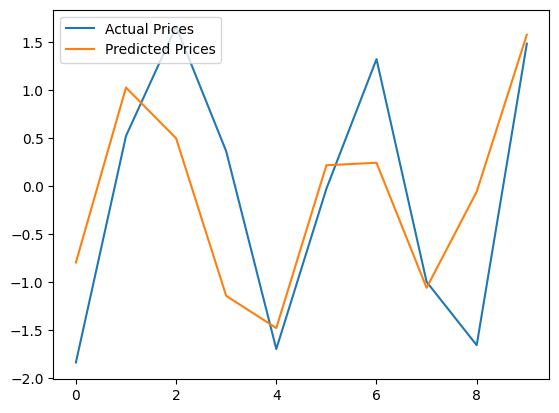

In [ ]:
import pandas as pd
train = data.diff().dropna()[0:240]
test = data.diff().dropna()[240:250]

# Import the ARMA module from statsmodels
from statsmodels.tsa.arima.model import ARIMA
fcst = []
for step in range(len(test)):
    # Forecast the first MA(1) model
    mod = ARIMA(train.reset_index(drop=True), order=(0,0,1))
    res = mod.fit()
    orig_data = data.diff().dropna()
    pred = res.predict()
    fcst += list(res.forecast(steps = 1))
    train = train.append(pd.Series(test[step]))
print(r2_score(list(test), fcst))
plt.plot(list(test))
plt.plot(fcst)
plt.legend(['Actual Prices', 'Predicted Prices'])
plt.show()


## Listing 4-10. Grid search to obtain the MA order that optimizes forecasting R2

In [ ]:
def evaluate2(order):
    train = data.diff().dropna()[0:240]
    test = data.diff().dropna()[240:250]

    fcst = []
    for step in range(len(test)):
        # Forecast the first MA(1) model
        mod = ARIMA(train.reset_index(drop=True), order=(0,0,order))
        res = mod.fit()
        orig_data = data.diff().dropna()
        pred = res.predict()
        fcst += list(res.forecast(steps = 1))
        train = train.append(pd.Series(test[step]))

    return r2_score(list(test), fcst)

scores = []
for i in range(1, 21):
    scores.append((i, evaluate2(i)))

# observe best order is 4 with R2 of 0.566
scores = pd.DataFrame(scores)
print(scores[scores[1] == scores.max()[1]])


<ipython-input-27-df2aa2df15e9>:13: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(pd.Series(test[step]))
<ipython-input-27-df2aa2df15e9>:13: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(pd.Series(test[step]))
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-27-df2aa2df15e9>:13: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(pd.Series(test[step]))
<ipython-input-27-df2aa2df15e9>:13: FutureWarning: The series.append method is deprecated and will be removed from pandas in a fut

   0         1
3  4  0.567555


## Listing 4-11. Obtaining the final forecast

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
<ipython-input-16-b1bcb281da05>:16: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(pd.Series(test[step]))
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
<ipython-input-16-b1bcb281da05>:16: FutureWarning: The series.append method is deprecated and will b

0.4891848104687161


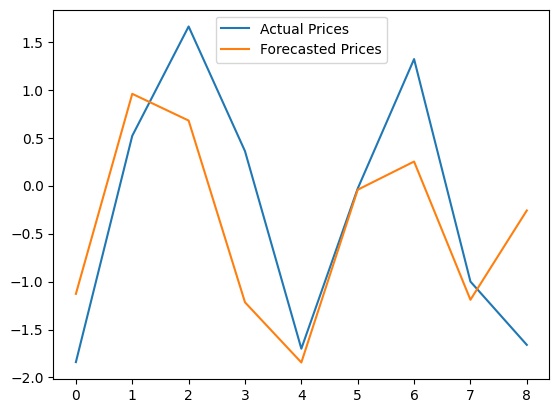

In [ ]:
train = data.diff().dropna()[0:240]
test = data.diff().dropna()[240:250]

fcst = []
for step in range(len(test)):
    # Forecast the first MA(1) model
    mod = ARIMA(train.reset_index(drop=True), order=(0,0,4))
    res = mod.fit()


    orig_data = data.diff().dropna()
    pred = res.predict()

    fcst += list(res.forecast(steps = 1))

    train = train.append(pd.Series(test[step]))

print(r2_score(list(test), fcst))

plt.plot(list(test))
plt.plot(fcst)
plt.legend(['Actual Prices', 'Forecasted Prices'])
plt.show()
